In [1]:
import pickle

import pandas as pd
import numpy as np
from tensorflow import keras

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
embeddings_2d = pickle.load(open('../feat_eng/embeddings_2d.pkl', 'rb'))

In [3]:
embeddings_2d
df = pd.read_csv('../data/data.csv', index_col=0)
print(embeddings_2d.shape)
print(df.shape)

(49450, 2)
(49450, 3)


### Clusters of word embeddings

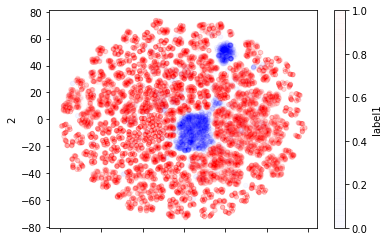

In [4]:
ebd_2d = pd.DataFrame(embeddings_2d, columns=[1, 2])
ebd_2d['label1'] = df['binary']
ebd_2d.plot.scatter(x=1, y=2, c='label1', colormap='bwr', alpha=0.01)

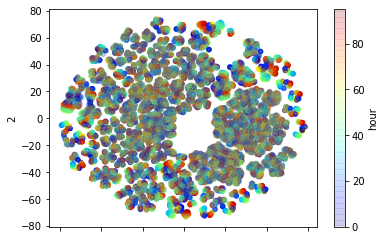

In [5]:
ebd_2d['hour'] = LabelEncoder().fit_transform(df['label'])
ebd_2d[ebd_2d['label1']==1].plot.scatter(x=1, y=2, c='hour', colormap='jet', alpha=0.1)

### Bag of n-grams model

In [6]:
df = pd.read_csv('../data/data.csv', index_col=0)
df.head()

text  label  binary
0            well at around five eight p.m. i think      17       1
1               oh around half to nine a.m. i think     8.3       1
2  it had to be around two fifty eight p.m. i sup...  14.45       1
3  oh it might have been at around quarter to thr...   2.45       1
4             well at around seven fifty three p.m.   19.45       1

In [7]:
def custom_tokenizer(string):
    return string.split(' ')
cv = pickle.load(open('cv_binary.pkl', 'rb'))
binary = pickle.load(open('binary.pkl', 'rb'))

In [8]:
def get_binary_prediction(string):
    model_input = cv.transform([string]).toarray()
    return binary.predict(model_input)

sentence that's certainly wrong

In [9]:
get_binary_prediction('this is just a random sentence')

array([0])

sentence that's certainly right

In [10]:
get_binary_prediction('i fell asleep around ten fourty p.m.')

array([1])

In [11]:
get_binary_prediction('i fell asleep around fourty ten p.m.')

array([0])

In [12]:
X = df['text'].apply(lambda x: str(x))
y = df['binary']
_, X_test, _, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
state = np.random.randint(100000)
sample_X = X_test.sample(n=10, random_state=state)
sample_y = y_test.sample(n=10, random_state=state)
for sample, true in zip(sample_X, sample_y):
    print(f'Predicted: {get_binary_prediction(sample)[0]}, True: {true}')

Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1


#### Multi Class

In [14]:
df = df[df['binary'] == 1] # take only those observations, where the answer is valid
X = df['text'].apply(lambda x: str(x))
y = df[['label']]

In [15]:
cv = pickle.load(open('cv_multi.pkl', 'rb'))
multi = pickle.load(open('rfc.pkl', 'rb'))
ohe = pickle.load(open('ohe.pkl', 'rb'))

In [16]:
CNN_model = keras.models.load_model('../feat_eng/CNN_model')
LSTM_model = keras.models.load_model('../feat_eng/LSTM_model')

In [17]:
_, X_test, _, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
y_test_ohe = ohe.transform(y_test)

In [19]:
model_input = cv.transform(X_test)
predicted_multi = multi.predict(model_input)

In [20]:
df = df[df['binary']==1]
word_dict = pd.Series(pd.Series(' '.join(df['text']).split(' ')).unique())
word_dict = word_dict.append(pd.Series('<PADDING>'))
word_dict = word_dict.reset_index()[0]

X_test = X_test.apply(lambda sentence: [np.where(word_dict == f'{x}')[0][0] for x in sentence.split(' ')])
X_test = pad_sequences(X_test, padding='post', maxlen=16, value=62)

In [21]:
predicted_CNN = CNN_model.predict(X_test)
predicted_LSTM = LSTM_model.predict(X_test)

In [22]:
multi_acc = (np.argmax(predicted_multi, axis=1) == np.squeeze(np.argmax(y_test_ohe, axis=1))).mean()

In [23]:
cnn_acc = (np.argmax(predicted_CNN, axis=1) == np.squeeze(np.argmax(y_test_ohe, axis=1))).mean()

In [24]:
lstm_acc = (np.argmax(predicted_LSTM, axis=1) == np.squeeze(np.argmax(y_test_ohe, axis=1))).mean()

In [25]:
print(f' RFC accuracy: {multi_acc}\n CNN accuracy: {cnn_acc} \n LSTM acc: {lstm_acc}')

 RFC accuracy: 0.9805387205387205
 CNN accuracy: 1.0 
 LSTM acc: 0.9993939393939394


In [26]:
def RFC_answer(answer):
    input_ = cv.transform([answer])
    prediction = multi.predict(input_)
    names = ohe.categories_[0]
    print(f'RFC output: {names[np.argmax(prediction)]}')

def CNN_answer(answer):
    input_ = [np.where(word_dict == f'{x}')[0][0] if x in word_dict.values else 62 for x in answer.split(' ')]
    input_ = pad_sequences([input_], padding='post', maxlen=16, value=62)
    cnn_pred = CNN_model.predict([input_])
    print(f'CNN output: {ohe.categories_[0][np.argmax(cnn_pred)]}')
    
def LSTM_answer(answer):
    input_ = [np.where(word_dict == f'{x}')[0][0] if x in word_dict.values else 62 for x in answer.split(' ')]
    input_ = pad_sequences([input_], padding='post', maxlen=16, value=62)
    lstm_pred = LSTM_model.predict([input_])
    print(f'LSTM output: {ohe.categories_[0][np.argmax(lstm_pred)]}')

In [27]:
answer = 'i have fallen asleep around half past eight a.m.'

for model in [RFC_answer, CNN_answer, LSTM_answer]:
    model(answer)

RFC output: 8.3
CNN output: 8.3
LSTM output: 8.3
